# Live Streamer Recommender with Implicit feedback
> A recommendation system based on implicit data (watch duration) of users to different streamers. Contains also clustering of these users based from the behavior/relationship to the different streamers

- toc: true
- badges: true
- comments: true
- categories: [Implicit, Optuna, Clustering, Surprise, SVD]
- author: "<a href='https://github.com/karlountalan/recommendation-system-implicit'>Karlo Untalan</a>"
- image:

## **Importing the initial needed libraries**

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px

import random

from sklearn.model_selection import train_test_split as train_test_split_sk
from sklearn.cluster import KMeans

!pip install scikit-surprise
from surprise.model_selection.search import GridSearchCV
from surprise import Reader,Dataset, accuracy,SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate, train_test_split

!pip install optuna
import optuna

!pip install implicit
import implicit

import scipy.sparse as sparse


     |████████████████████████████████| 11.8MB 253kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617667 sha256=3fbc6d342da03fc1ac6dc0efdb08e37d8d85114c99d297ae6845a0c173f70668
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise
     |████████████████████████████████| 307kB 5.4MB/s 
     |████████████████████████████████| 174kB 8.9MB/s 
     |████████████████████████████████| 81kB 6.3MB/s 
     |████████████████████████████████| 81kB 6.3MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 143kB 9.8MB/s 
     |████████████████████████████████| 112kB 11.5MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11136 sha256=8c3e2f8361815b2814d42a3b5db3522e89984d8bd02cdc570e2f0ebcce245394
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff

## **Importing the datasets downloaded from Google BigQuery**

In [ ]:
#Individual Channel streams information dataset
df_channel = pd.read_csv('/content/drive/MyDrive/kumu_data/kumu_channel_db.csv')

#Watchlog for both gameshow and livestreams of the users dataset
df_gameshow = pd.read_csv('/content/drive/MyDrive/kumu_data/kumu_gameshow_watchlog_db.csv')
df_ls1 = pd.read_csv('/content/drive/MyDrive/kumu_data/kumu_livestream_watchlog_db_p1.csv')
df_ls2 = pd.read_csv('/content/drive/MyDrive/kumu_data/kumu_livestream_watchlog_db_p2.csv')

#Relationship dataset between users and streamers
df_rel = pd.read_csv('/content/drive/MyDrive/kumu_data/kumu_reco_dataset.csv')



/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



## **Some Feature Engineering and EDA (Part 1 and Part 2)**

In [ ]:
#Concatenating the two separated livestream watchlog because of the separation due to file size contraints
df_livestream = pd.concat([df_ls1,df_ls2],axis=0)
df_livestream = df_livestream.rename(columns={'viewer_id':'user_id'})

#Concatenating the livestream watchlog and gameshow watchlog
df_all = pd.concat([df_livestream,df_gameshow],axis=0)

#Summing up those entries with the same User_id and channel_ID
df_all = df_all.groupby(['user_id','channel_id']).agg({'duration':sum}).reset_index()


In [ ]:
df_all.head(5)

,user_id,channel_id,duration
0,00000a8a-b9de-44de-88d4-4adc741eb7d8,047fa399-c17c-49d3-87ad-0bf01b727970,509
1,00000a8a-b9de-44de-88d4-4adc741eb7d8,096ce938-d230-40bd-9535-7efc1811725f,205
2,00000a8a-b9de-44de-88d4-4adc741eb7d8,0e4bfeb8-e82d-4e42-86f5-fb8b595364ad,2400
3,00000a8a-b9de-44de-88d4-4adc741eb7d8,0ef82015-b499-4658-8b3e-4eb4678ea46a,5216
4,00000a8a-b9de-44de-88d4-4adc741eb7d8,12301120-6ce1-45af-871b-b745523fb101,659


In [ ]:
df_channel.head(5)

,channel_id,streamer_id,type,duration,schedule,like_count,comment_count,description,gifts,diamonds,live_type,video,is_live,total_viewer,total_joined_times,live_current_audience,live_start_time,updated_at,created_at,scheduled_time,engagement_count,live_day
0,e8c3b45b-8e75-48cc-8425-803690327635,28fa0539-3d09-4890-a353-268abbe12d88,2,8873,NaN,81026,310,NaN,88,15839,1,1,no,33,400,0,2020-04-21 12:54:02 UTC,2020-04-20 17:54:11 UTC,2020-04-20 05:54:01 UTC,NaN,81336,Tuesday
1,58685176-f8e3-440c-91fe-618ee44d4b4e,52ddb3ed-03d6-4478-a9e9-960c3a6bfae3,2,3870,NaN,89530,367,NaN,895,60847,1,1,no,207,471,0,2020-04-03 02:42:52 UTC,2020-04-03 10:42:59 UTC,2020-04-02 15:42:51 UTC,NaN,89897,Friday
2,cc7750d6-4b0e-4f18-9461-eba6f564cfac,8e14bc8c-3871-43dc-b474-36b39959025f,2,159,NaN,26816,1213,NaN,426,58408,1,1,no,449,744,0,2020-04-23 10:14:35 UTC,2020-04-21 22:14:40 UTC,2020-04-22 20:14:30 UTC,NaN,28029,Thursday
3,34deef1e-76d0-44aa-adc9-c759d108f829,42a21c7a-2171-4d7c-9215-459e0fa6c60c,2,11467,NaN,116444,865,NaN,725,34973,1,1,no,257,597,0,2020-04-02 23:56:13 UTC,2020-04-03 01:56:19 UTC,2020-04-03 15:56:12 UTC,NaN,117309,Thursday
4,afb701d5-3355-4708-8977-a819b0d028b6,3392c81e-543a-4fd7-8a43-0bc0518d059e,2,3912,NaN,59964,1232,NaN,202,74560,1,1,no,32,133,0,2020-04-03 11:22:11 UTC,2020-04-03 20:22:17 UTC,2020-04-04 12:22:10 UTC,NaN,61196,Friday


Getting the day of the week using the live_start_time column...

In [ ]:
df_channel['live_day'] = df_channel['live_start_time'].apply(lambda x: pd.to_datetime(x,format='%Y-%m-%d %H:%M:%S %Z').strftime('%A'))

In [ ]:
#joining the channel df to get the details of every channel_id
df = pd.merge(df_all,df_channel,how='left',on='channel_id')
df = df.rename(columns={'duration_x':'user_duration','duration_y':'total_stream_duration'})

In [ ]:
df.head()

,user_id,channel_id,user_duration,streamer_id,type,total_stream_duration,schedule,like_count,comment_count,description,gifts,diamonds,live_type,video,is_live,total_viewer,total_joined_times,live_current_audience,live_start_time,updated_at,created_at,scheduled_time,engagement_count,live_day
0,00000a8a-b9de-44de-88d4-4adc741eb7d8,047fa399-c17c-49d3-87ad-0bf01b727970,509,eda6f19c-b5a5-40df-9629-4ca000b83c8d,2.0,8850.0,NaN,300666.0,18456.0,NaN,796.0,109343.0,1.0,1.0,no,1876.0,3341.0,0.0,2020-04-07 10:50:30 UTC,2020-04-08 07:07:04 UTC,2020-04-09 02:50:29 UTC,NaN,319122.0,Tuesday
1,00000a8a-b9de-44de-88d4-4adc741eb7d8,096ce938-d230-40bd-9535-7efc1811725f,205,5b1e89d2-8717-46d8-b6a8-56af39d0ad16,2.0,11877.0,NaN,121177.0,3367.0,NaN,1285.0,132561.0,1.0,1.0,no,1797.0,2636.0,0.0,2020-04-08 23:10:16 UTC,2020-04-09 07:32:47 UTC,2020-04-08 15:09:27 UTC,NaN,124544.0,Wednesday
2,00000a8a-b9de-44de-88d4-4adc741eb7d8,0e4bfeb8-e82d-4e42-86f5-fb8b595364ad,2400,07dadd40-5706-45d0-a611-b9414ccec20a,2.0,8387.0,NaN,187158.0,4813.0,NaN,926.0,72005.0,1.0,1.0,no,969.0,1849.0,0.0,2020-04-08 01:33:46 UTC,2020-04-08 16:08:18 UTC,2020-04-08 12:33:19 UTC,NaN,191971.0,Wednesday
3,00000a8a-b9de-44de-88d4-4adc741eb7d8,0ef82015-b499-4658-8b3e-4eb4678ea46a,5216,cf0fafde-bb77-4fd6-a0fb-b433dfc312a5,2.0,21591.0,NaN,228009.0,2146.0,NaN,2171.0,113491.0,1.0,1.0,no,1824.0,3632.0,0.0,2020-04-16 15:03:53 UTC,2020-04-16 17:17:06 UTC,2020-04-12 23:30:58 UTC,2020-04-16 19:00:00 UTC,230155.0,Thursday
4,00000a8a-b9de-44de-88d4-4adc741eb7d8,12301120-6ce1-45af-871b-b745523fb101,659,2b5ea87a-53ae-4e8c-b181-8fe1aba19f00,2.0,10925.0,NaN,42188.0,1213.0,NaN,2163.0,120375.0,1.0,1.0,no,2660.0,4379.0,0.0,2020-04-11 09:23:58 UTC,2020-04-13 00:41:22 UTC,2020-04-12 11:22:38 UTC,2020-04-11 21:30:00 UTC,43401.0,Saturday


**Plotting the Distribution Plot of the Watch Duration of Users**

Text(0.5, 0, 'user_watch_duration (s)')

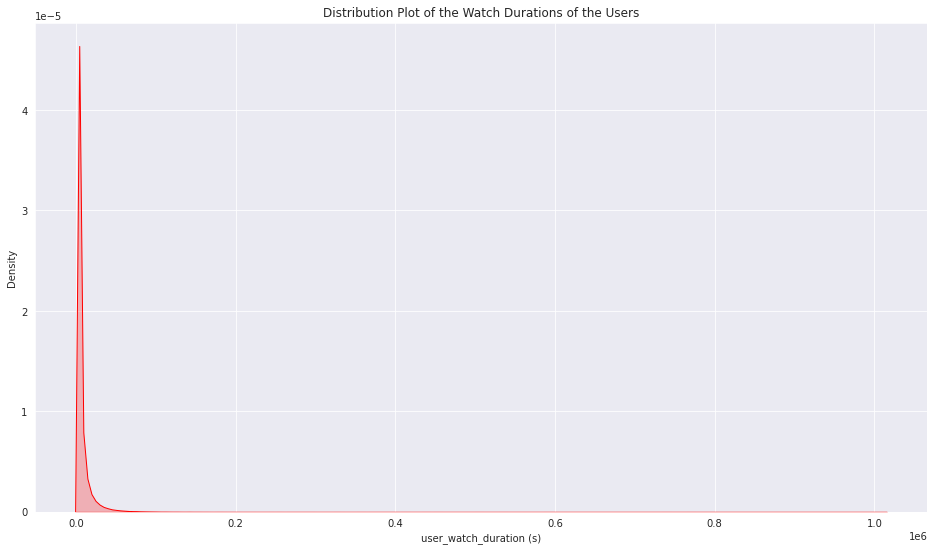

In [ ]:
plt.figure(figsize=(16,9))
sns.set_style('darkgrid')
sns.kdeplot(df['user_duration'], shade=True, color='r')
plt.title('Distribution Plot of the Watch Durations of the Users')
plt.xlabel('user_watch_duration (s)')

In [ ]:
df['user_duration'].describe()

count    6.496318e+06
mean     3.346421e+03
std      7.599363e+03
min      1.000000e+00
25%      9.570000e+02
50%      1.784000e+03
75%      2.635000e+03
max      1.014573e+06
Name: user_duration, dtype: float64

The skewness signifies that the distribution of the user_duration is heavily right skewed

The Kurtosis signifies that the distribution is too peaked

In [ ]:
#Skewness and kurtosis of the watch durations
print('Skewness: %f' % df['user_duration'].skew())
print('Kurtosis: %f' % df['user_duration'].kurtosis())

Skewness: 12.606066
Kurtosis: 392.330756


Getting the summary of the data per day of the week...

In [ ]:
df_day = df.groupby(['live_day']).agg({'user_id': lambda x: x.nunique(),'streamer_id': lambda y: y.nunique(),'user_duration':sum}).reset_index()
df_day = df_day.rename(columns={'user_id':'total_unique_viewers','streamer_id':'total_unique_streamers','user_duration':'total_watch_duration'})

In [ ]:
df_day

,live_day,total_unique_viewers,total_unique_streamers,total_watch_duration
0,Friday,88768,12592,3024113614
1,Monday,83127,12756,3012746358
2,Saturday,85307,12921,3073650023
3,Sunday,83735,12819,3066008868
4,Thursday,86319,12635,3063017868
5,Tuesday,86836,13198,3107610539
6,Wednesday,87251,13132,3054886081


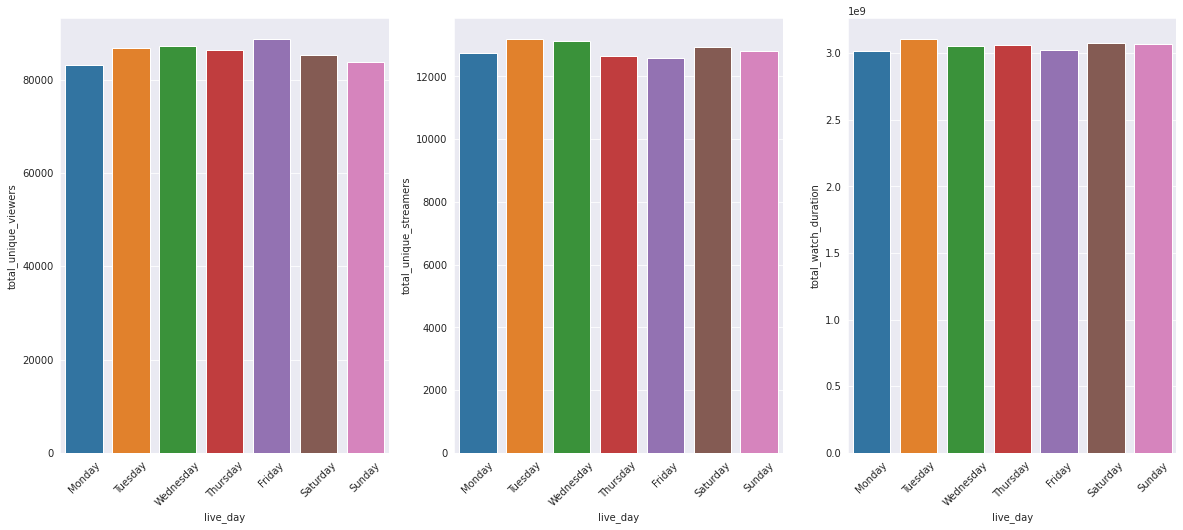

In [ ]:
g, axes = plt.subplots(1,3, figsize=(20,8))
sns.set_style('dark')
sns.barplot(x='live_day', y='total_unique_viewers', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],data=df_day,ax=axes[0])
label1 = axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45)

sns.barplot(x='live_day', y='total_unique_streamers', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],data=df_day,ax=axes[1])
label2 = axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=45)
sns.barplot(x='live_day', y='total_watch_duration', order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],data=df_day,ax=axes[2])
label3 = axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation=45)



The graph and table signifies that there are no significant difference in the number of total unique streamers and viewers during any day of the week. Same goes with the total watch duration.

However based from the graph, we can see that **Friday** is the day where the number of viewers peaked and then **decreases** on **Sunday and Monday**

The number of streamers is at peak on **Tuesdays, Wednesdays, and Saturdays**

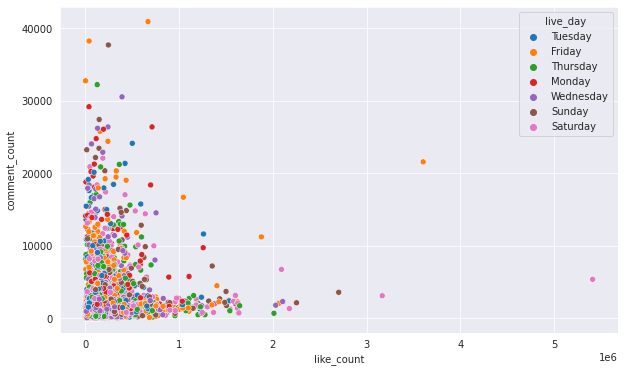

In [ ]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.scatterplot(x='like_count',y='comment_count',data=df_channel,hue='live_day')

The like count and comment count doesn't show a linear relationship as expected. There are streams with few likes but high comments and vice versa. We will make a new column and add these two variable and we'll call it "**engagement count"**

In [ ]:
df_channel['engagement_count']=df_channel['like_count']+df_channel['comment_count']

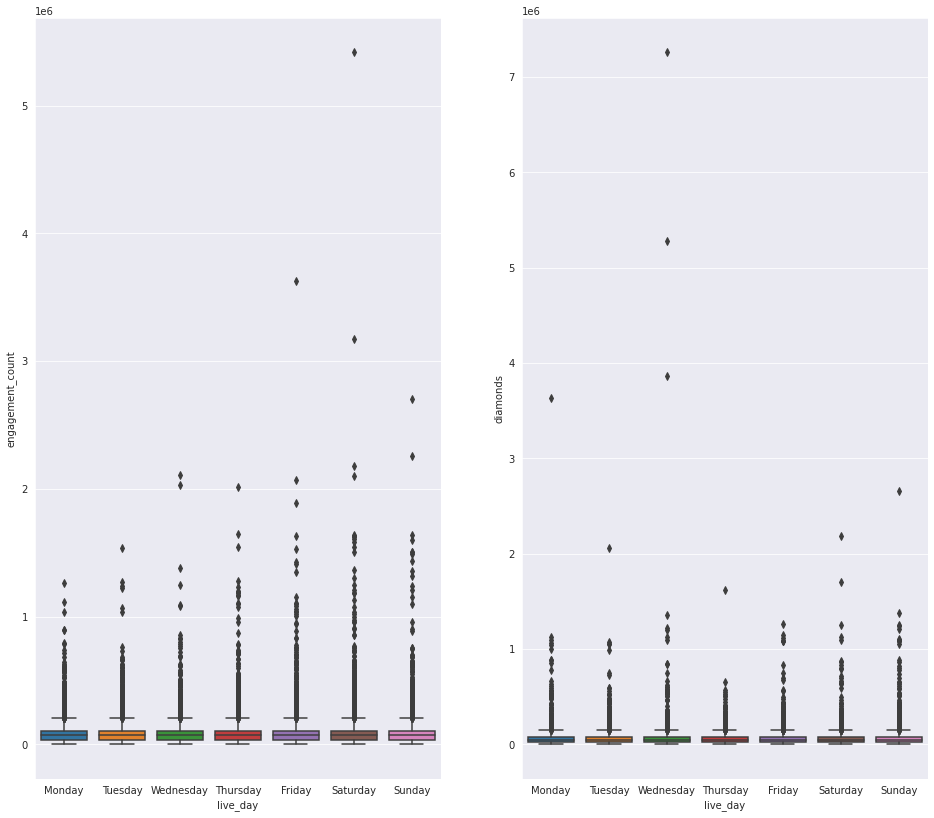

In [ ]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
g, axes = plt.subplots(1,2, figsize=(16,14))
sns.set_style('darkgrid')
sns.boxplot(x='live_day',y='engagement_count',data=df_channel,order=days,ax=axes[0])
sns.boxplot(x='live_day',y='diamonds',data=df_channel,order=days,ax=axes[1])

The value of the 1st quartile and 3rd quartile of all the days are similar but we can see a very high value of engagement count outlier during the days of **Friday, Saturday, Sunday**

Same for the diamonds received per day of week. All of the days are similar.

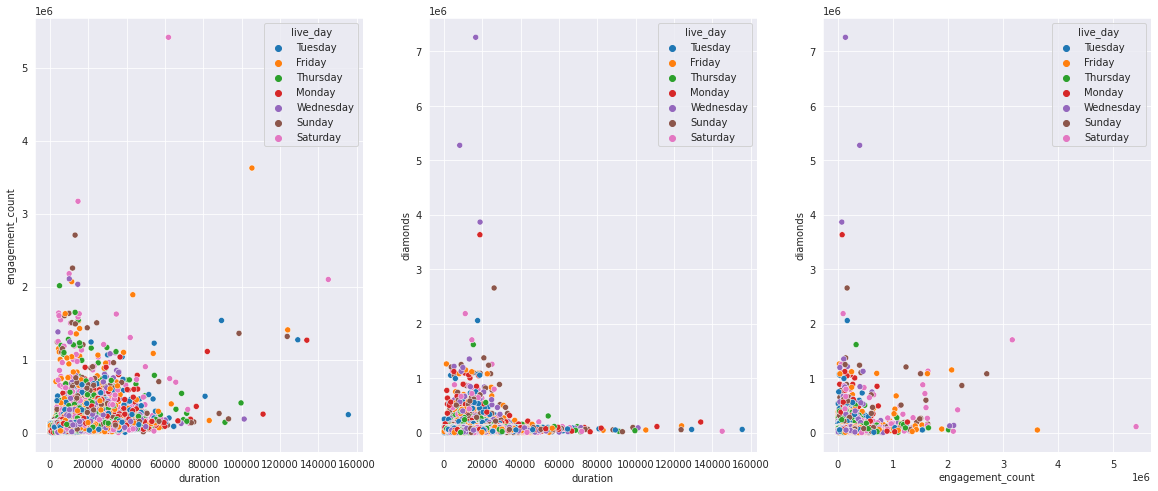

In [ ]:
g, axes = plt.subplots(1,3, figsize=(20,8))
sns.set_style('darkgrid')
sns.scatterplot(x='duration',y='engagement_count',data=df_channel,hue='live_day',ax=axes[0])
sns.scatterplot(x='duration',y='diamonds',data=df_channel,hue='live_day',ax=axes[1])
sns.scatterplot(x='engagement_count',y='diamonds',data=df_channel,hue='live_day',ax=axes[2])

There is a linear relationship somehow between the stream duration and the engagement count

There is no linear relationship between the engagement_count and the diamonds received.

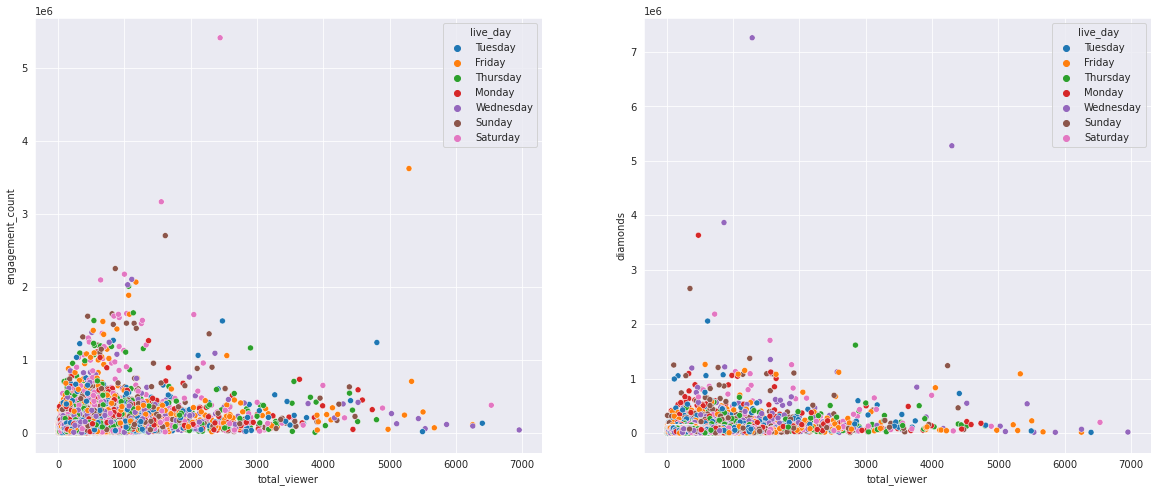

In [ ]:
g, axes = plt.subplots(1,2, figsize=(20,8))
sns.set_style('darkgrid')
sns.scatterplot(x='total_viewer',y='engagement_count',data=df_channel,hue='live_day',ax=axes[0])
sns.scatterplot(x='total_viewer',y='diamonds',data=df_channel,hue='live_day',ax=axes[1])

The graph above is the relationship of the total viewer to engagement_count and diamonds

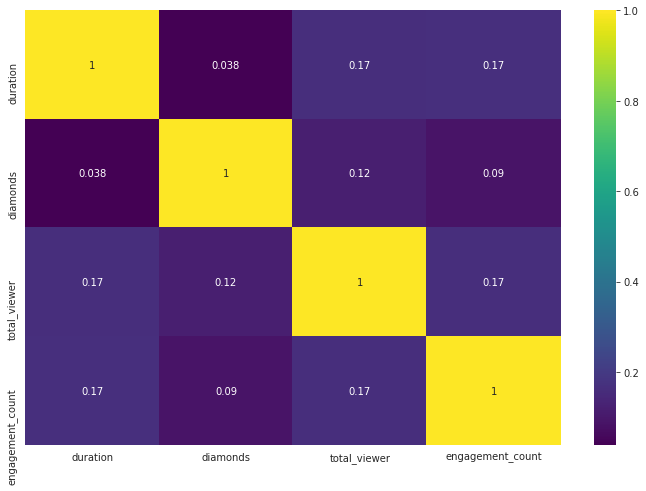

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df_channel[['duration','diamonds','total_viewer','engagement_count']].corr(), cmap='viridis', annot=True)

**Based from the heatmap above, there are no strong correlation between the variables in the stream_channels data.**

In [ ]:
df_rel.head(5)

,streamer_id,viewer_id,view_count,comment_count,coin_count
0,ef671ae0-7679-42c8-a994-c217eaf46529,6a5c4ab0-e376-4cc2-941d-21aef968015c,4,166,0
1,cb990028-4d02-4644-a62c-6c0cd7cd24a8,6a5c4ab0-e376-4cc2-941d-21aef968015c,1,19,0
2,d32cb11f-5a0c-4de3-97b8-f10271d80104,6a5c4ab0-e376-4cc2-941d-21aef968015c,3,37,200
3,6b68f813-61ed-4bc0-bcbf-112308cf8fb7,6a5c4ab0-e376-4cc2-941d-21aef968015c,8,49,1600
4,9b0b156c-1045-4e02-8492-b74c206bff91,6a5c4ab0-e376-4cc2-941d-21aef968015c,5,147,1625


I'm not sure how is the engagement factor is derived (not also stated in the schema of the table), for the sake of the analysis, I will remove this feature from the data.

In [ ]:
df_rel.drop('engagement',axis=1,inplace=True)

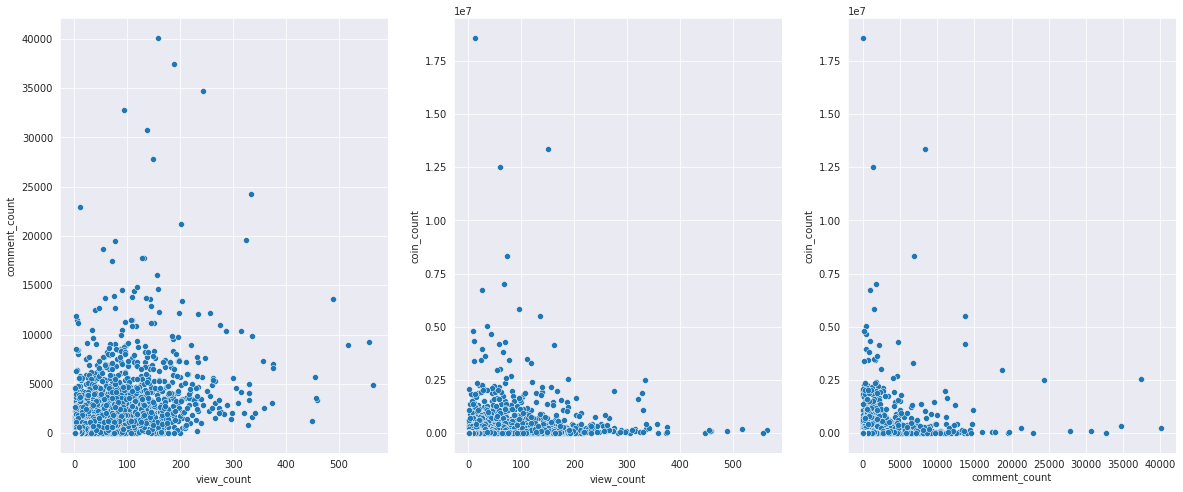

In [ ]:
g, axes = plt.subplots(1,3, figsize=(20,8))
sns.set_style('darkgrid')
sns.scatterplot(x='view_count',y='comment_count',data=df_rel,ax=axes[0])
sns.scatterplot(x='view_count',y='coin_count',data=df_rel,ax=axes[1])
sns.scatterplot(x='comment_count',y='coin_count',data=df_rel,ax=axes[2])

The **view count and comment count** somehow possess a **linear relationship**

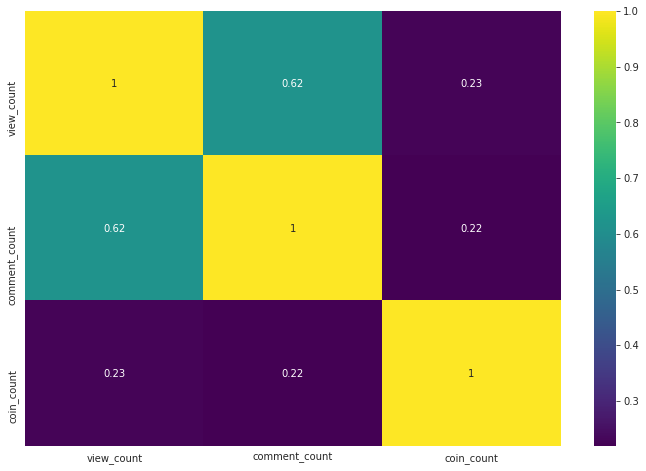

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(df_rel.corr(), cmap='viridis', annot=True)

Based from the heatmap above and the previous scatterplot, we can really see a strong linear relationship between view_count and comment_count in the relationship data table between users and streamers

The correlation of the coin_count to both the view_count and comment_count are almost the same.

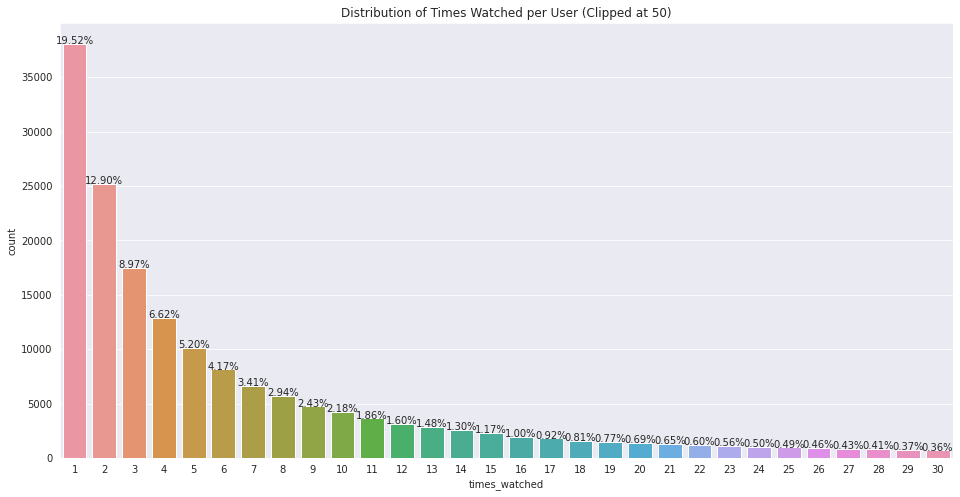

In [ ]:
df_users = pd.DataFrame(df['user_id'].value_counts()).reset_index()
df_users.columns = ['user_id','times_watched']
ax = plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
total = df_users['user_id'].nunique()
ax = sns.countplot(x='times_watched',data=df_users[df_users['times_watched']<=30])
tot_pct = 0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '{:1.2f}%'.format(height*100/total),
            ha="center")
    tot_pct+= height*100/total
tit = ax.set_title('Distribution of Times Watched per User (Clipped at 50)')
    

**Almost 20% of the users only watched ONCE in the dataset**

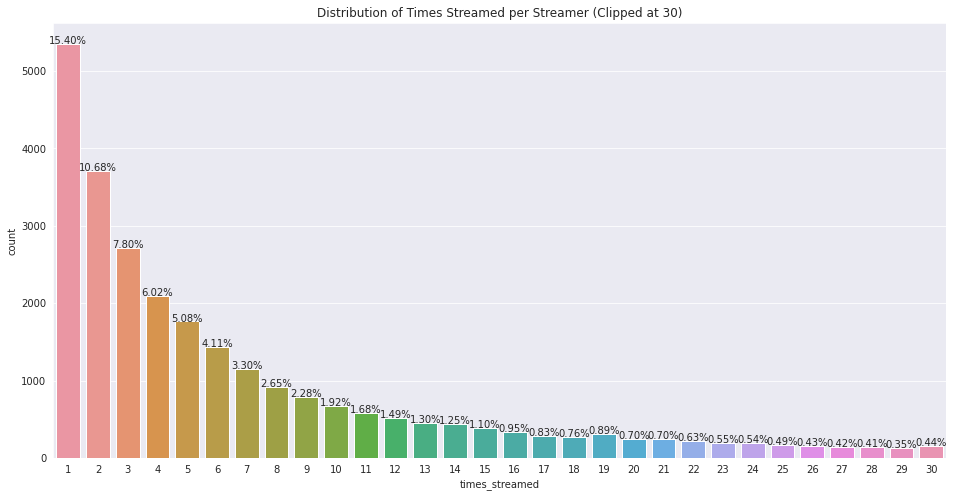

In [ ]:
df_streamers = pd.DataFrame(df['streamer_id'].value_counts()).reset_index()
df_streamers.columns = ['streamer_id','times_streamed']
ax = plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
total = df_streamers['streamer_id'].nunique()
ax = sns.countplot(x='times_streamed',data=df_streamers[df_streamers['times_streamed']<=30])
tot_pct = 0
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '{:1.2f}%'.format(height*100/total),
            ha="center")
    tot_pct+= height*100/total
tit = ax.set_title('Distribution of Times Streamed per Streamer (Clipped at 30)')
    

**Almost 16% of the streamers only streamed ONCE in the dataset**

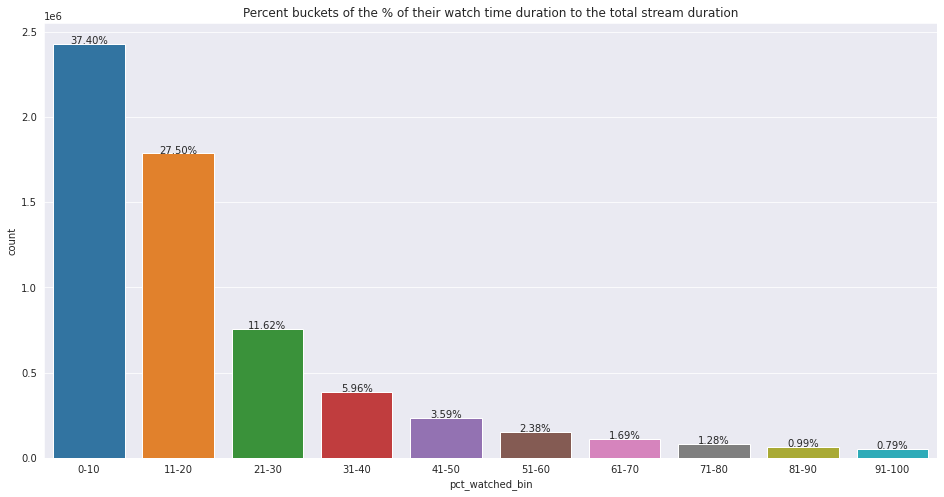

In [ ]:
df['pct_watched'] = df['user_duration']*100/df['total_stream_duration']
ranges = [0,10,20,30,40,50,60,70,80,90,100]
labels=['0-10','11-20','21-30',
        '31-40','41-50','51-60','61-70','71-80','81-90','91-100']
df['pct_watched_bin'] = pd.cut(df.pct_watched, ranges,labels=labels)

ax = plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
total = len(df)
ax = sns.countplot(x='pct_watched_bin',data=df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '{:1.2f}%'.format(height*100/total),
            ha="center")
tit = ax.set_title('Percent buckets of the % of their watch time duration to the total stream duration')

**Only 7% of the viewers watched more than 50% of the entire stream of a streamer in this data set**

## **Method 1 - Collaborative Filtering Using Model-Based CF (Part 1)**

### **Model Selection for the Recommender Model Using Surprise SVD (Part 1)**

Preparing the train data...

In [ ]:
df_cf = df.groupby(['user_id','streamer_id']).agg({'user_duration':np.mean}).reset_index()

Since one of our models in our model selection is SVD, we will scale our target variable...

In [ ]:
df_cf['scaled_user_duration'] = np.log(df_cf['user_duration'])
df_cf.head(5)

,user_id,streamer_id,user_duration,scaled_user_duration
0,00000a8a-b9de-44de-88d4-4adc741eb7d8,036902a2-159a-4b92-ba4a-4f812a22f9a4,3608.0,8.190909
1,00000a8a-b9de-44de-88d4-4adc741eb7d8,05ec0fd3-b1cd-4fa7-b332-290f0e930545,2303.0,7.741968
2,00000a8a-b9de-44de-88d4-4adc741eb7d8,07dadd40-5706-45d0-a611-b9414ccec20a,2400.0,7.783224
3,00000a8a-b9de-44de-88d4-4adc741eb7d8,101988eb-a72d-4826-b03c-76123d497ff3,2405.0,7.785305
4,00000a8a-b9de-44de-88d4-4adc741eb7d8,14a10840-8787-453d-8755-241515cc3c6d,740.0,6.606650


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



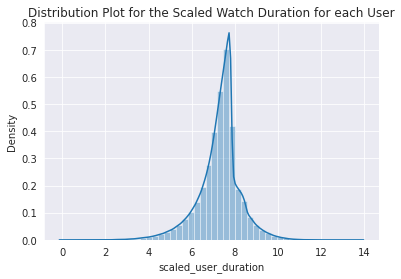

In [ ]:
g = sns.distplot(df_cf['scaled_user_duration'])
tit = g.set_title('Distribution Plot for the Scaled Watch Duration for each User')

In [ ]:
#Sampling the dataset for the initial model algorithm selection
sampled_df = df_cf.sample(n=100000)
reader = Reader(rating_scale=(0,df_cf['scaled_user_duration'].max()))
data = Dataset.load_from_df(sampled_df[['user_id','streamer_id','scaled_user_duration']], reader)
raw_duration = data.raw_ratings

#Shuffling the data
random.shuffle(raw_duration)

#Manually splitting train and test set after shuffling the data
# Train = 80% of the data, Test = 20% of the data
threshold = int(.8 * len(raw_duration))
train_raw_duration = raw_duration[:threshold]
test_raw_duration = raw_duration[threshold:]

data.raw_ratings = train_raw_duration # data is now the train set

In [ ]:
benchmark = []

#We will use SVD, SVDpp, NMF, and KNNWithMeans as our model choices
for algorithm in [SVD(), SVDpp(), NMF(), KNNWithMeans()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False,n_jobs=1)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

In [ ]:
results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,0.985955,4.007380,0.161621
SVDpp,0.989273,9.051058,0.257025
KNNWithMeans,1.119724,75.255755,1.819091
NMF,1.889590,6.654417,0.087605


Based from the Benchmarking above, using the defaults parameter values, SVD performs best in our dataset...

Checking if the model overfitted in our data by fitting it in our training set and testing it out on our hold-out set

In [ ]:
algo = SVD()
trainset = data.build_full_trainset()
algo.fit(trainset)
testset = data.construct_testset(test_raw_duration)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9755


0.9754630225685305

**The RMSE is almost the same as the RMSE loss with the cross validation... It means that the model didn't overfit with the data. We will proceed with SVD.**

### **Hyperparameter Optimization using Optuna**

**Getting the WHOLE dataset since we sampled the dataset earlier with 100k samples and building new train and test sets**

In [ ]:
data = Dataset.load_from_df(df_cf[['user_id','streamer_id','scaled_user_duration']], reader)
raw_duration = data.raw_ratings

# shuffle ratings if you want
random.shuffle(raw_duration)

# Train = 80% of the data, Test = 20% of the data
threshold = int(.8 * len(raw_duration))
train_raw_duration = raw_duration[:threshold]
test_raw_duration = raw_duration[threshold:]

data.raw_rating = train_raw_duration
trainset = data.build_full_trainset()

In [ ]:
import optuna

def objective(trial):
    n_factors = trial.suggest_int('n_factors', 70,300,10)
    n_epochs = trial.suggest_int('n_epochs', 6,16,2)
    reg_all = trial.suggest_uniform('reg_all',0.001,0.05)
    lr_all = trial.suggest_uniform('lr_all',0.00005,0.01)
    svd = SVD(n_factors=n_factors,n_epochs=n_epochs,reg_all=reg_all,lr_all=lr_all)

    return cross_validate(svd, data, measures=['RMSE'], cv=3, verbose=False,n_jobs=1)['test_rmse'].mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2021-06-18 00:10:20,470] A new study created in memory with name: no-name-3b264fd1-76de-49c4-a00e-caf3ee2e20f4
[I 2021-06-18 00:18:12,172] Trial 0 finished with value: 0.9615299988267841 and parameters: {'n_factors': 240, 'n_epochs': 8, 'reg_all': 0.032216298591381504, 'lr_all': 0.0030713589694045277}. Best is trial 0 with value: 0.9615299988267841.
[I 2021-06-18 00:25:54,381] Trial 1 finished with value: 0.9674370179508566 and parameters: {'n_factors': 300, 'n_epochs': 6, 'reg_all': 0.013084554217324264, 'lr_all': 0.0014119644680387054}. Best is trial 0 with value: 0.9615299988267841.
[I 2021-06-18 00:32:48,622] Trial 2 finished with value: 0.9604558697676606 and parameters: {'n_factors': 210, 'n_epochs': 8, 'reg_all': 0.03945821450891387, 'lr_all': 0.003696354400070709}. Best is trial 2 with value: 0.9604558697676606.
[I 2021-06-18 00:39:04,616] Trial 3 finished with value: 0.9647385367580528 and parameters: {'n_factors': 190, 'n_epochs': 8, 'reg_all': 0.018611071900602977, 'lr_al

[I 2021-06-18 03:34:36,719] Trial 32 finished with value: 0.9603077582726884 and parameters: {'n_factors': 120, 'n_epochs': 10, 'reg_all': 0.04125105281105273, 'lr_all': 0.0007601306699048511}. Best is trial 18 with value: 0.9587833069419219.
[I 2021-06-18 03:39:05,085] Trial 33 finished with value: 0.959059583508437 and parameters: {'n_factors': 100, 'n_epochs': 8, 'reg_all': 0.0470937671112176, 'lr_all': 0.0012126034618256919}. Best is trial 18 with value: 0.9587833069419219.
[I 2021-06-18 03:44:11,599] Trial 34 finished with value: 0.9591641536421536 and parameters: {'n_factors': 130, 'n_epochs': 8, 'reg_all': 0.04709107449163972, 'lr_all': 0.0014966022184484669}. Best is trial 18 with value: 0.9587833069419219.
[I 2021-06-18 03:54:11,583] Trial 35 finished with value: 0.9603463950172576 and parameters: {'n_factors': 270, 'n_epochs': 10, 'reg_all': 0.046239596788272865, 'lr_all': 0.002550896038157493}. Best is trial 18 with value: 0.9587833069419219.
[I 2021-06-18 03:57:53,276] Tria

[I 2021-06-18 06:52:22,536] Trial 65 finished with value: 0.9583733182885544 and parameters: {'n_factors': 100, 'n_epochs': 14, 'reg_all': 0.028533166426005018, 'lr_all': 0.0014504331136707435}. Best is trial 42 with value: 0.9580308963605431.
[I 2021-06-18 06:57:21,213] Trial 66 finished with value: 0.9590791915082653 and parameters: {'n_factors': 80, 'n_epochs': 10, 'reg_all': 0.023620240456741753, 'lr_all': 0.0028524072184592667}. Best is trial 42 with value: 0.9580308963605431.
[I 2021-06-18 07:05:37,108] Trial 67 finished with value: 0.9586769652596496 and parameters: {'n_factors': 110, 'n_epochs': 16, 'reg_all': 0.0262946763094995, 'lr_all': 0.0009441371465171193}. Best is trial 42 with value: 0.9580308963605431.
[I 2021-06-18 07:10:10,717] Trial 68 finished with value: 0.9589398676349302 and parameters: {'n_factors': 70, 'n_epochs': 10, 'reg_all': 0.015268082729203727, 'lr_all': 0.002074801038491802}. Best is trial 42 with value: 0.9580308963605431.
[I 2021-06-18 07:16:04,143] T

[I 2021-06-18 10:09:11,850] Trial 98 finished with value: 0.9585522591554924 and parameters: {'n_factors': 90, 'n_epochs': 10, 'reg_all': 0.038876186059440945, 'lr_all': 0.0029007098873479725}. Best is trial 81 with value: 0.9577032600967129.
[I 2021-06-18 10:17:44,584] Trial 99 finished with value: 0.9600171495064398 and parameters: {'n_factors': 200, 'n_epochs': 10, 'reg_all': 0.03689630959516972, 'lr_all': 0.002301410598138786}. Best is trial 81 with value: 0.9577032600967129.


**Getting the BEST hyperparameter combination using the output of the study...**

**From 0.986 to 0.958 RMSE loss using the optimized hyperparameters**

In [ ]:
study.best_params

{'lr_all': 0.001427237312606455,
 'n_epochs': 14,
 'n_factors': 70,
 'reg_all': 0.028138308089573162}

In [ ]:
study.best_value

0.9577032600967129

**Fitting the model to the WHOLE train dataset**

In [ ]:
params = {'lr_all': 0.001427237312606455,
 'n_epochs': 14,
 'n_factors': 70,
 'reg_all': 0.028138308089573162}
 
algo = SVD(n_factors = params['n_factors'],n_epochs=params['n_epochs'],reg_all=params['reg_all'],lr_all=params['lr_all'])

algo.fit(trainset)
testset = data.construct_testset(test_raw_duration)

**Checking for the performance on the WHOLE test set... Looks like the hyperparamter optimization really improved our model and it didn't overfit..**

**We got 0.9339 RMSE on our hold-out set...**

In [ ]:
testset = data.construct_testset(test_raw_duration)
predictions = algo.test(testset)
accuracy.rmse(predictions)


RMSE: 0.9339


0.9338573527407598

Getting the RMSE in a non logarithmic space since we transformed our target variable into a log space

In [ ]:
def get_real_rmse(preds):
  err2 = []
  for i in range(len(preds)):
    err = (np.exp(preds[i][2])-np.exp(preds[i][3]))**2
    err2.append(err)
  return (np.sqrt(np.mean(err2)))

get_real_rmse(predictions)

3692.6892442643652

### **Model in Action**

Function definition that accepts a user_id and a streamer ID and outputs an estimate watch duration (in seconds).

In [ ]:
def get_est_duration(uid,iid):
  log_est = algo.predict(uid,iid)[3]
  est_dur = np.exp(log_est)
  return est_dur

In [ ]:
get_est_duration('ffff2b91-308d-4ac8-8bad-c255f9bbd187','56c17686-ad3e-4ba8-a21a-402720862f14')

3945.0078655997295

**Building a recommender function that will accept input of a user_id and output the top n streamer that he/she will likely like.**

**The "only_new" parameter is a boolean variable to identify whether to return only NEW streamers that the user haven't watched yet or no.**

**When a NEW user is inputted, it will return the top 10 streamer with highest watch time based from all the users.**

**Number of recommendations can be changed by changing the parameter num_reco. Default value is 10**

In [ ]:
def recommend_streamer(uid,only_new=True,num_reco=10):
  if uid not in df_cf['user_id'].unique():
    df = df_cf.groupby(['streamer_id']).agg({'user_duration':sum}).reset_index().sort_values(['user_duration'],ascending=False).iloc[0:num_reco].reset_index(drop=True)
    df.columns = ['streamer_id','total_duration_from_other_users']
  else:
    if only_new:
      watched = df_cf[df_cf['user_id']==uid]['streamer_id'].values
      all_streamers = df_cf['streamer_id'].unique()
      streamers = [i for i in all_streamers if i not in watched]
    else:
      streamers = df_cf['streamer_id'].unique()
    df = pd.DataFrame(streamers,columns=['streamer_id'])
    df['est_duration'] = df['streamer_id'].apply(lambda x: np.exp(algo.predict(uid,x)[3]))
    df = df.sort_values(['est_duration'],ascending=False).iloc[0:num_reco,:].reset_index(drop=True)
  return df



In [ ]:
recommend_streamer('unknown-user-id')

,streamer_id,total_duration_from_other_users
0,696f5ce2-2a16-41c4-86a5-a4ca0ece4b75,1.007918e+08
1,47e84b92-db34-427c-9bfb-92123a46ff4c,8.931283e+07
2,2ba8b462-65a9-4994-b1dc-2da13e984525,5.866176e+07
3,87624042-88e3-4e6f-98ba-1af61513c291,5.184067e+07
4,eda6f19c-b5a5-40df-9629-4ca000b83c8d,4.935504e+07
5,d32cb11f-5a0c-4de3-97b8-f10271d80104,4.869629e+07
6,39fbcd8a-60a7-4d1e-ab5a-21b3a17cf8c5,4.797923e+07
7,2b5ea87a-53ae-4e8c-b181-8fe1aba19f00,4.316949e+07
8,bed68351-2d5c-447f-be65-0c491d021f23,4.015313e+07
9,dc39b4a3-c5f3-4b65-88fc-d438f5913be0,3.403732e+07


In [ ]:
recommend_streamer('00000a8a-b9de-44de-88d4-4adc741eb7d8')

,streamer_id,est_duration
0,56c17686-ad3e-4ba8-a21a-402720862f14,4093.472246
1,844b63ee-a29d-4b37-8671-bcefda1be8d6,3497.373588
2,0f4b6348-6d9d-412e-bca4-72f618f7cffd,3311.208256
3,b6ad3eac-2769-421c-9ab3-134e9a960f53,3138.430681
4,f75c9b27-3069-41f7-b970-8af3c4a33718,3004.913903
5,f6d4f6a5-03c1-43cd-8e95-85502639526f,2869.477587
6,33b7b1d5-3eeb-49a7-a258-eeeaca940bc8,2795.524950
7,d44cf950-4975-494d-96b4-1c9e767c3650,2789.649334
8,979c79ef-e020-4265-b622-70f327518138,2764.784122
9,0888897f-26de-4e63-9575-8ae5abb143a0,2758.571402


## **Method 2 - Collaborative Filtering Using ALS with Implicit Feedback Using Implicit Library (Part 1)**

Based from the paper: http://yifanhu.net/PUB/cf.pdf

In [ ]:
#Preparing the Sparse Matrix that will be fitted to the ALS

sparse_streamer_user = sparse.csr_matrix((df_cf['user_duration'].astype(float), 
                                          (df_cf['streamer_id'].astype('category').cat.codes, df_cf['user_id'].astype('category').cat.codes)))
sparse_user_streamer = sparse.csr_matrix((df_cf['user_duration'].astype(float), 
                                          (df_cf['user_id'].astype('category').cat.codes, df_cf['streamer_id'].astype('category').cat.codes)))

users_dict = dict(zip(df_cf.user_id.astype('category'), df_cf.user_id.astype('category').cat.codes))
streamers_dict = dict(zip( df_cf.streamer_id.astype('category').cat.codes, df_cf.streamer_id.astype('category')))

In [ ]:
# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=50)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(sparse_streamer_user)

In [ ]:
def recommend_streamers(uid,user_streamers):
    recommendations = model.recommend(users_dict[uid],user_streamers,filter_already_liked_items=False)
    iid = []
    scores = []
    for i in recommendations:
        iid.append(streamers_dict[i[0]])
        scores.append(i[1])
    return pd.DataFrame(zip(iid,scores),columns=['streamer_id','score'])

List of Streamers really watched by user **ffffe69c-b408-44e4-b611-def853fd19f6** based from his/her watchlog

In [ ]:
df_cf[df_cf['user_id']=='ffffe69c-b408-44e4-b611-def853fd19f6'][['streamer_id','user_duration']].sort_values('user_duration',ascending=False)

,streamer_id,user_duration
4164812,26842c36-490b-41ad-8ee1-403b43f78021,4738.0
4164814,eda6f19c-b5a5-40df-9629-4ca000b83c8d,1339.0
4164813,696f5ce2-2a16-41c4-86a5-a4ca0ece4b75,577.0


List of Streamers recommended by our ALS engine to the user **ffffe69c-b408-44e4-b611-def853fd19f6**

In [ ]:
recommend_streamers('ffffe69c-b408-44e4-b611-def853fd19f6',user_streamers)

,streamer_id,score
0,eda6f19c-b5a5-40df-9629-4ca000b83c8d,1.007727
1,696f5ce2-2a16-41c4-86a5-a4ca0ece4b75,1.005641
2,26842c36-490b-41ad-8ee1-403b43f78021,1.002171
3,9f4f0007-a78b-43ca-a3c6-5f4ef7c36d97,0.746720
4,bd694008-47dd-4e0b-8617-e07bc1fc38b0,0.723268
5,33515df0-9753-4dc4-a8f8-4adad822b059,0.699990
6,b9402b91-ca61-4cc8-8d0d-0bde017fac40,0.685309
7,a8cfc211-6940-4cde-9f10-25df6193fee4,0.675624
8,c1d318e0-6e05-475e-9709-1a54a1251746,0.667296
9,b210f6a2-c54a-4089-bdd7-716ce43667ff,0.655615


**Based from the tables above, all of the streamers watched by user ffffe69c-b408-44e4-b611-def853fd19f6 ended up in our top recommendation for that user.**

### **Evaluating the implicit ALS Recommender Engine**

Based from the methodology in https://towardsdatascience.com/building-a-collaborative-filtering-recommender-system-with-clickstream-data-dffc86c8c65 and https://nbviewer.jupyter.org/github/jmsteinw/Notebooks/blob/master/RecEngine_NB.ipynb



We basically **mask/remove some values in our sparse matrix in our training set** and then compare with the final recommendation if the masked values are included in the recommendation. The test set will contain the unmasked and complete data.

In [ ]:
def make_train(ratings, pct_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered  

Splitting the data into training set and validation set. Also returns the user_ids that were masked for evaluation.

In [ ]:
train, test, users_altered = make_train(sparse_user_streamer, pct_test = 0.2)

In [ ]:
from sklearn import metrics
def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    
    - predictions: your prediction output
    
    - test: the actual target result you are comparing to
    
    returns:
    
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)   

In [ ]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for i,user in enumerate(altered_users):
        # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    score = float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))
    score = pd.DataFrame(score).T
    score.columns = ['recommender_AUC_score','popularity_AUC_score']
    
    return score  

Implementing the ALS on the users and streamers data.

Also uses an alpha of 40 since the paper used this value of alpha

In [ ]:
alpha = 40

user_vecs, item_vecs = implicit.alternating_least_squares((train*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)

calc_mean_auc(train, users_altered, 
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], test)



,recommender_AUC_score,popularity_AUC_score
0,0.921,0.979


**Our ALS recommender model performed great as it gets 0.921 AUC score. It means that streamers recommended by our recommender ended up really watched by our users based from their historical watchlog.**

**However, recommender using streamer popularity garnered a higher AUC score and outperforms our ALS recommender engine.**

## **Conclusion in the Recommendation Model**

As we can see, the RMSE of the first method we did was ~3693s which is ***not a great score*** even though the model didn't overfit in our data. However, we got a promising evaluating score in our second method but it can't exactly predict the definite duration for a user-streamer pair but it's much better in recommending compared to the performance given by our first method.

## **Clustering of the Users and Streamers (Part 2)**

We will be clustering the users and streamers based from their **total streams viewed/streamed, total comments given/received, and total coins given/received.**

In [ ]:
df_viewer = df_rel.groupby(['viewer_id']).agg({'view_count':sum,'comment_count':sum,'coin_count':sum}).reset_index()
df_viewer.columns = ['viewer_id','total_streams_viewed','total_comments_given','total_coins_given']
df_streamer = df_rel.groupby(['streamer_id']).agg({'view_count':sum,'comment_count':sum,'coin_count':sum}).reset_index()
df_streamer.columns = ['streamer_id','total_streams','total_comments_received','total_coins_received']

In [ ]:
df_viewer

,viewer_id,total_streams_viewed,total_comments_given,total_coins_given
0,00007068-55b1-46a4-b3db-8736dd2a3c89,1,1,0
1,00029616-d8e1-479c-9e32-569154c885eb,4,25,10
2,0002ba14-9409-4e9d-b160-bc3025e3b035,1,0,20
3,0006ca63-ec80-4e38-a370-2a6502c2650d,2,5,0
4,000c75cf-e01c-4478-98b4-611d92b53a1d,27,203,870
...,...,...,...,...
32011,fff6e675-bed6-4dbc-b16d-2a5ca8b6c77d,191,302,5390
32012,fff8418d-0128-4c02-95f2-f630aec0a3c1,8,35,10
32013,fff853c2-8ac3-462d-afe9-c475f3c8fba2,1,7,10
32014,fffd4c43-24f3-4e9a-990c-726c724e14a7,3,3,0


### **Using KMeans Algorithm in Clustering**

We will use the **Elbow Method** in determining the optimal number of clusters.

In [ ]:
from sklearn.cluster import KMeans

def elbow_method(df):
  #Using Streams viewed/streamed, coin given/received, and comments given/received as the clustering factors...
  xcluster3d = df.values
  wcss = []
  for i in range(1,15):
      km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 500, n_init = 20, random_state = 42)
      km.fit(xcluster3d)
      wcss.append(km.inertia_)
  plt.figure(figsize=(12,8))
  sns.set_style('darkgrid')
  g = sns.lineplot(x=range(1,15),y=wcss,color='r')
  g.set_title('Elbow Method')
  g.set_xlabel("Clusters")
  g.set_ylabel("WCSS")


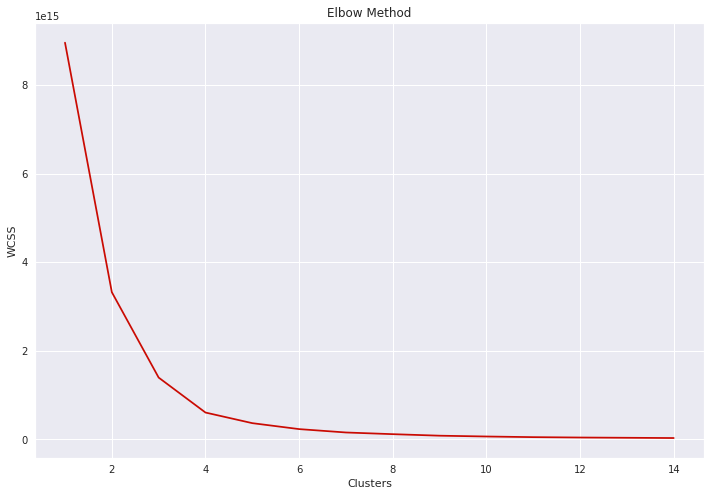

In [ ]:
elbow_method(df_viewer[['total_streams_viewed','total_comments_given','total_coins_given']])

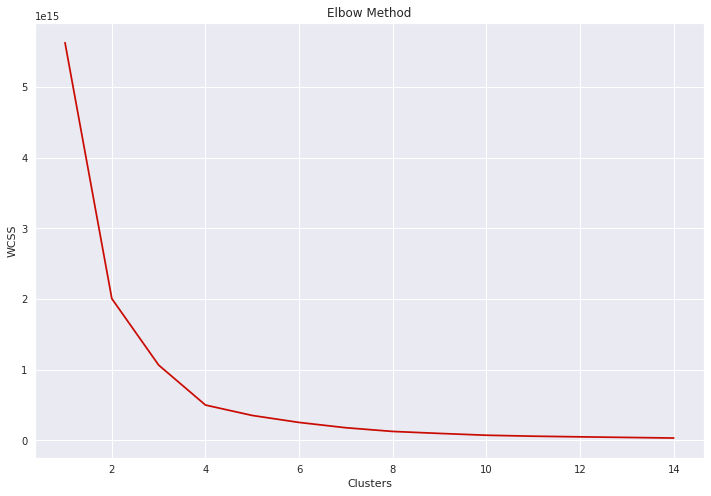

In [ ]:
elbow_method(df_streamer[['total_streams','total_comments_received','total_coins_received']])

Our optimal clusters are **4** for **both streamers and viewers**...


In [ ]:
#Applying the optimal clusters to the kmeans
km3d_viewer = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 500, n_init = 20, random_state = 42)
km3d_streamer = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 500, n_init = 20, random_state = 42)
kcluster3d_viewer = km3d_viewer.fit_predict(df_viewer[['total_streams_viewed','total_comments_given','total_coins_given']])
kcluster3d_streamer = km3d_streamer.fit_predict(df_streamer[['total_streams','total_comments_received','total_coins_received']])
df_viewer['cluster']=kcluster3d_viewer
df_viewer['cluster'] = df_viewer['cluster'].apply(lambda x: 'Cluster '+str(x+1))
df_streamer['cluster']=kcluster3d_streamer
df_streamer['cluster'] = df_streamer['cluster'].apply(lambda x: 'Cluster '+str(x+1))

In [ ]:
fig = px.scatter_3d(df_streamer, x='total_streams', y='total_comments_received', z='total_coins_received',
              color='cluster')
fig.show()

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df_viewer, x='total_streams_viewed', y='total_comments_given', z='total_coins_given',
              color='cluster')
fig.show()

**Based from the two 3D graphs above for the clustering of streamers and viewers, the algorithm mainly clustered the data by how the user and streamer gives and receives coins, respectively.**